# Analyzing the relationship between education level and violent crime in California counties


**Team Members**
1. Kyle Choi
2. Nithila Balaji
3. Khalil Burrell

**Topic Overview**

Our aim is to see if there is a correlation between education level and violent crime in California. In order to do this we will calculate high school drop out rate as a parameter of education among different counties along with violent crime in two specific years and observe the relation (if there is one). We will then calculate the average across both years and see if we are able to generalize a relationship.


In [87]:
# Imports

import pandas as pd
import numpy as np
import statsmodels.api as sm

## Data Collection and Cleaning

**Dataset 1: Violent Crime data**

insert source and give basic info

In [88]:
## insert cleaned data and small explanation on steps taken

In [89]:
crime_data = pd.read_csv('violent_crime_data.csv')

# Converting string value to integers

crime_data['2017'] = crime_data['2017'].str.replace(',', '').astype(float)
crime_data['2022'] = crime_data['2022'].str.replace(',', '').astype(float)


crime_data['2017'] = pd.to_numeric(crime_data['2017'])
crime_data['2022'] = pd.to_numeric(crime_data['2022'])

crime_data.head()

,County,2017,2022
0,Alameda,9923.0,11125.0
1,Alpine,13.0,11.0
2,Amador,115.0,136.0
3,Butte,921.0,1291.0
4,Calaveras,208.0,257.0


**Dataset 2: Graduation data**

insert source

In [90]:
# Load data

grad_17 = pd.read_csv('2017gradrate.csv')
grad_22 = pd.read_csv('2022gradrate.csv')

In [91]:
grad_17.columns

Index(['AcademicYear', 'AggregateLevel', 'CountyCode', 'CountyName',
       'DistrictName', 'SchoolName', 'CharterSchool', 'ReportingCategory',
       'CohortStudents', 'Regular HS Diploma Graduates (Count)',
       'Regular HS Diploma Graduates (Rate)', 'Met UC/CSU Grad Req's (Count)',
       'Met UC/CSU Grad Req's (Rate)', 'Seal of Biliteracy (Count)',
       'Seal of Biliteracy (Rate)', 'Golden State Seal Merit Diploma (Count)',
       'Golden State Seal Merit Diploma (Rate', 'CHSPE Completer (Count)',
       'CHSPE Completer (Rate)', 'Adult Ed. HS Diploma (Count)',
       'Adult Ed. HS Diploma (Rate)', 'SPED Certificate (Count)',
       'SPED Certificate (Rate)', 'GED Completer (Count)',
       'GED Completer (Rate)', 'Other Transfer (Count)',
       'Other Transfer (Rate)', 'Dropout (Count)', 'Dropout (Rate)',
       'Still Enrolled (Count)', 'Still Enrolled (Rate)'],
      dtype='object')

In [92]:
# We will only select the necessary columns for our analysis

# List of columns to keep
columns_to_keep = ['CountyName', 'CohortStudents', 'Dropout (Count)']

# Remove all columns except the specified ones
grad_17 = grad_17[columns_to_keep]
grad_22 = grad_22[columns_to_keep]

In [142]:
grad_17.head()

,CountyName,CohortStudents,Dropout (Count)
0,Alameda,153,50
1,Alameda,198,74
2,Alameda,*,*
3,Alameda,161,62
4,Alameda,*,*


In [94]:
# Convert all data to integers and fill missing values with 0

grad_17_sub = grad_17.copy()

grad_17_sub = grad_17_sub.replace('*', np.nan).dropna()
grad_17_sub['CohortStudents'] = pd.to_numeric(grad_17_sub['CohortStudents'])
grad_17_sub['Dropout (Count)'] = pd.to_numeric(grad_17_sub['Dropout (Count)'])

grad_22_sub = grad_22.copy()
grad_22_sub = grad_22_sub.replace('*', np.nan).dropna()

grad_22_sub['CohortStudents'] = pd.to_numeric(grad_22_sub['CohortStudents'])
grad_22_sub['Dropout (Count)'] = pd.to_numeric(grad_22_sub['Dropout (Count)'])


In [135]:
grad_17_sub.head()

,CountyName,CohortStudents,Dropout (Count),Dropout_Rate_17
0,Alameda,506348,45814,9.047928
1,Amador,9216,882,9.570312
2,Butte,74011,6604,8.922998
3,Calaveras,16327,767,4.697740
4,Colusa,10482,302,2.881130


In [96]:
# Originally each high school was listed separately. We want to groupby county and have the total sums

grad_17_sub=grad_17_sub.groupby('CountyName').sum()
grad_22_sub=grad_22_sub.groupby('CountyName').sum()

In [97]:
grad_17_sub.head()

,CohortStudents,Dropout (Count)
CountyName,,
Alameda,506348,45814
Amador,9216,882
Butte,74011,6604
Calaveras,16327,767
Colusa,10482,302


In [98]:
grad_22_sub.head()

,CohortStudents,Dropout (Count)
CountyName,,
Alameda,335763,27480
Amador,5827,250
Butte,48227,4118
Calaveras,7839,259
Colusa,7102,276


In [99]:
# Make single dataframe with rates from both

grad_17_sub = grad_17_sub.reset_index()
grad_22_sub = grad_22_sub.reset_index()

# Calculate dropout rates

grad_17_sub['Dropout_Rate_17'] = (grad_17_sub['Dropout (Count)'] / grad_17_sub['CohortStudents']) * 100
grad_22_sub['Dropout_Rate_22'] = (grad_22_sub['Dropout (Count)'] / grad_22_sub['CohortStudents']) * 100

df_merged = pd.merge(grad_17_sub[['CountyName', 'Dropout_Rate_17']], grad_22_sub[['CountyName', 'Dropout_Rate_22']], on='CountyName', how='outer')

# Rename columns for clarity

df_merged.rename(columns={'CountyName': 'County', 'Dropout_Rate_17': 'Dropout_17', 'Dropout_Rate_22': 'Dropout_22'}, inplace=True)
df_merged.head()

,County,Dropout_17,Dropout_22
0,Alameda,9.047928,8.184344
1,Amador,9.570312,4.290372
2,Butte,8.922998,8.538785
3,Calaveras,4.697740,3.303993
4,Colusa,2.881130,3.886229


## Regression

**Crime Rate per county based on their estimated population**

source: https://dof.ca.gov/forecasting/demographics/estimates/

**Hypotheses**

Null Hypothesis (H$_0$): There is no relationship between violent crime rates and high school graduation rate across counties in California in the two selected years.

Alternate Hypothesis (H$_a$): There is a positive relationship between violent crime and high school graduation rates across counties in California in the two selected years.


In [115]:
# Combine data

df_combined = df_merged.copy()
Pop_2017 = pd.read_excel('Population2010-2020.xlsx', sheet_name=1)['Unnamed: 8'][1:-1].reset_index().drop(columns= ['index'])['Unnamed: 8']
Pop_2022 = pd.read_excel('Population2024.xlsx', sheet_name=1)['Unnamed: 3'][2:-1].reset_index().drop(columns= ['index'])['Unnamed: 3']
df_combined['Crime_Rate_2017'] = crime_data['2017'] / Pop_2017 * 100
df_combined['Crime_Rate_2022'] = crime_data['2022'] / Pop_2022 * 100
df_combined.head()

,County,Dropout_17,Dropout_22,Crime_Rate_2017,Crime_Rate_2022
0,Alameda,9.047928,8.184344,0.603478,0.676834
1,Amador,9.570312,4.290372,1.119724,0.92437
2,Butte,8.922998,8.538785,0.311653,0.339915
3,Calaveras,4.697740,3.303993,0.408484,0.62614
4,Colusa,2.881130,3.886229,0.460483,0.570845


In [101]:
df_combined['Change_in_Dropout'] = (df_combined['Dropout_22'] - df_combined['Dropout_17']).astype(float)
df_combined['Change_in_Crime'] = (df_combined['Crime_Rate_2022'] - df_combined['Crime_Rate_2017']).astype(float)


<AxesSubplot:>

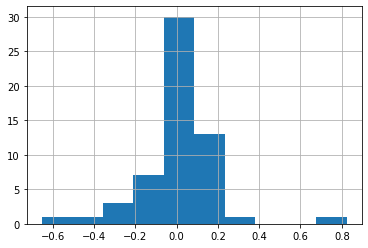

In [102]:
df_combined['Change_in_Crime'].hist()

<AxesSubplot:>

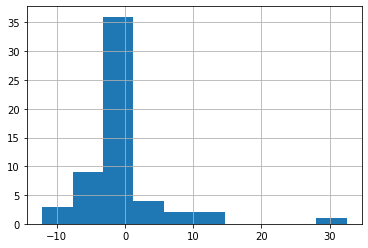

In [103]:
df_combined['Change_in_Dropout'].hist()

Since the distribution is skewed, we will employ log to make it normal

<AxesSubplot:>

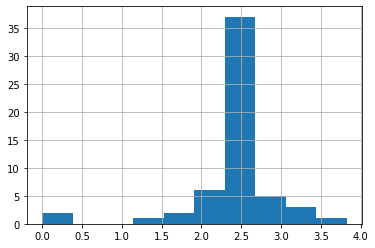

In [107]:
if (df_combined['Change_in_Dropout'] <= 0).any():
    df_combined['Logged_Change_in_Dropout'] = df_combined['Change_in_Dropout'] + 1 - df_combined['Change_in_Dropout'].min()
df_combined['Logged_Change_in_Dropout'] = np.log(df_combined['Logged_Change_in_Dropout'])
df_combined['Logged_Change_in_Dropout'].hist()

In [108]:
X = sm.add_constant(df_combined['Logged_Change_in_Dropout'])
y = df_combined['Change_in_Crime']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Change_in_Crime   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.141
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.290
Time:                        15:59:37   Log-Likelihood:                 12.788
No. Observations:                  57   AIC:                            -21.58
Df Residuals:                      55   BIC:                            -17.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1379      0.116      1.184      0.241      -0.095       0.371
Logged_Change_in_Dropout    -0.0500      0.047     -1.068      0.290      -0.144       0.044
==============================================================================
Omnibus:                       16.230   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.097
Skew:                           0.272   Prob(JB):                     2.99e-17
Kurtosis:                       8.634   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. **Low R-squared**: The R-squared value is 0.021, which suggests that only about 2.1% of the variability in changes in crime rates is explained by changes in dropout rates. This is quite low, indicating a weak model fit.

2. **P-value of the F-statistic**: The Prob (F-statistic) is 0.281, which is much greater than the typical significance level of 0.05. This suggests that the model is not statistically significant, meaning that changes in dropout rates may not be a good predictor of changes in crime rates based on this model.

3. **Coefficient for `Change_in_Dropout`**: The coefficient is -0.0046 with a p-value of 0.281. This again indicates that the effect of changes in dropout rates on changes in crime rates is not statistically significant at the conventional levels.

4. **Distribution of Residuals**: The high values for skewness and kurtosis, along with significant results from the Omnibus and Jarque-Bera tests, suggest that the residuals of your model are not normally distributed. This can affect the validity of the regression analysis, as normality of residuals is an assumption of OLS regression.


In [212]:
counties = [
    'Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 
    'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 
    'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 
    'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 
    'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 
    'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 
    'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 
    'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 
    'Tuolumne', 'Ventura', 'Yolo', 'Yuba'
]

In [213]:
df_new_combined = pd.DataFrame(index = counties)
df_new_combined = df_new_combined.merge(df_merged, left_index = True, right_on = 'County',how = 'left').fillna(0).set_index('County')

In [203]:
from sklearn.preprocessing import StandardScaler
df_new_combined['Change_in_Dropout'] = df_new_combined['Dropout_22'] - df_new_combined['Dropout_17']\
if df_new_combined['Change_in_Dropout'].var() != 0 and not df_new_combined['Change_in_Dropout'].isna().all():
    scaler = StandardScaler()
    df_new_combined['Scaled_Dropout'] = scaler.fit_transform(df_new_combined[['Change_in_Dropout']].dropna())
else:
    print("Variance is zero or all values are NaN. Scaling skipped.")

results = {}
coefficients = {}

for index, row in df_new_combined.iterrows():
    county = index
    file_path = f'{county}.csv'
    
    df_crime = pd.read_csv(file_path)
    df_crime['2022'] = pd.to_numeric(df_crime['2022'], errors='coerce')
    df_crime['2017'] = pd.to_numeric(df_crime['2017'], errors='coerce')

    df_crime['Change_in_Crime'] = df_crime['2022'] - df_crime['2017']
    if not np.isnan(row.get('Scaled_Dropout', np.nan)):
        X = sm.add_constant(pd.DataFrame({'Scaled_Dropout': [row['Scaled_Dropout']] * len(df_crime)}))
        Y = df_crime['Change_in_Crime'].dropna()

        if not Y.empty and len(Y) > 1:
            model = sm.OLS(Y, X.loc[Y.index]).fit()
            results[county] = model

for county, model in results.items():
    print(f"Results for {county}:")
    print(model.summary())
    coefficients[county] = model.params


Results for Alameda:
                            OLS Regression Results                            
Dep. Variable:        Change_in_Crime   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 08 Jun 2024   Prob (F-statistic):                nan
Time:                        16:59:09   Log-Likelihood:                -116.38
No. Observations:                  20   AIC:                             234.8
Df Residuals:                      19   BIC:                             235.8
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Scaled_Dropout   329.15

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))



Results for Placer:
                            OLS Regression Results                            
Dep. Variable:        Change_in_Crime   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 08 Jun 2024   Prob (F-statistic):                nan
Time:                        16:59:09   Log-Likelihood:                -279.79
No. Observations:                  45   AIC:                             561.6
Df Residuals:                      44   BIC:                             563.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Scaled_Dropout   204.86

In [210]:
coef_df = pd.DataFrame(coefficients).T
coef_df.sort_values(by ='Scaled_Dropout', ascending = False)

,Scaled_Dropout
Sutter,21288.748816
Monterey,1602.011359
San Mateo,838.667420
Sacramento,735.354761
Alameda,329.153058
San Joaquin,277.205318
Madera,247.128849
Riverside,225.262845
Placer,204.860430
Fresno,199.303094


**Positive Coefficients**: Counties with positive coefficients suggest that an increase in the dropout rate is associated with an increase in crime rates. For instance, Sutter, Monterey, and San Mateo showing large positive coefficients imply a significant positive relationship between dropout rates and crime rates.

**Negative Coefficients**: Conversely, counties like Butte and Shasta with large negative coefficients suggest that increases in dropout rates are associated with significant decreases in crime rates—though this might also indicate data anomalies or other factors worth investigating further.

## Analysis

## Conclusion